# Exercise 2

## Helper functions

In [1]:
import numpy as np
import cv2 
import os

def load_im(path : str) -> np.ndarray:
    
    im = cv2.imread(path)[:, :, ::-1]
    im = im.astype(np.float64) / 255
    
    return im
    

## Ex 2.1


### Functions

In [2]:
import itertools as it

def box3d(n=16):
    points = []
    N = tuple(np.linspace(-1, 1, n))
    
    for i, j in [(-1, -1), (-1, 1), (1, 1), (0, 0)]:
        points.extend(set(it.permutations([(i, )*n, (j, )*n, N])))
        
    return np.hstack(points)/2


def pi(points : np.ndarray) -> np.ndarray:
    """
        Converts from homogeneous to inhomogeneous coordinates
    """
    p = points[:-1]/points[-1]
    
    return p


def piInv(points : np.ndarray) -> np.ndarray:
    """
        Converts from inhomogeneous to homogeneous coordinates
    """
    
    # Gets the amount of points by using shape
    _, num_points = points.shape
    
    # Stacks the scale s at the bottom of the matrix
    ph = np.vstack((points, np.ones(num_points)))
    
    return ph


def projectPoints(K, Rt, Q):
    
    Q_hom = piInv(Q)
    points = K @ Rt @ Q_hom
    points_inhom = pi(points)
    
    return points_inhom

### Response

**Given a traditional camera, what is the resolution in pixels?**
We thought that since $(x,y)$ are displaced by $\delta x = \delta y = 400$, then the resolution might be $800 \times 800$ pixels.

**Are all the points are captured by the image sensor?**
We think so, see image below.

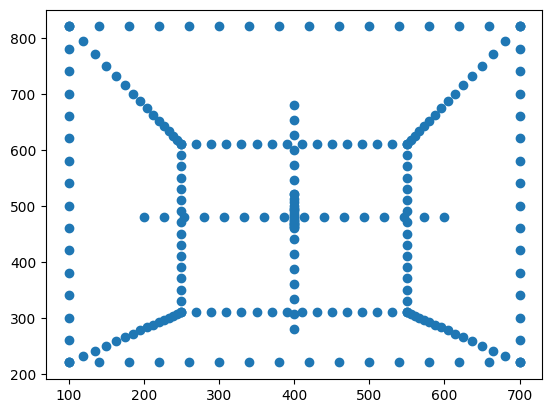

In [3]:
import matplotlib.pyplot as plt

# We define K as per slide 12 of week 2
f = 600
alpha = 1
beta = 0
deltax = 400
deltay = 400
K = np.array(
    [[f, beta*f, deltax],
     [0, alpha*f, deltay],
     [0, 0, 1]]
    )

R = np.diag(np.ones(3))
t = np.array([[0, 0.2, 1.5]])
Rt = np.concatenate((R, t.T), axis=1)

Q = box3d(n=16)

Qp = projectPoints(K, Rt, Q)

plt.scatter(Qp[0, :], Qp[1, :])
plt.show()

**Where does the corner $\pmb{P}_1 = [-0.5, -0.5, -0.5]$ project to?** 

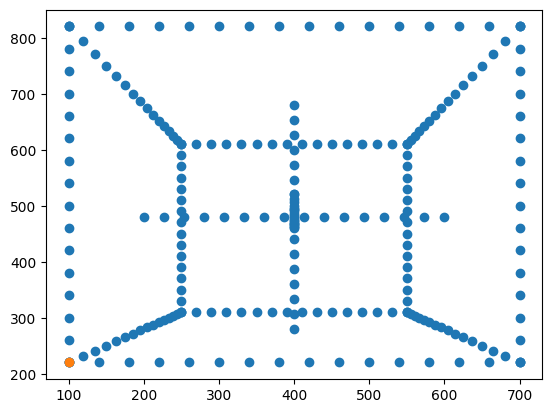

In [4]:
P1 = np.array([[-0.5, -0.5, -0.5]])
P1p = projectPoints(K, Rt, P1.T)

plt.scatter(Qp[0, :], Qp[1, :])
plt.scatter(P1p[0, :], P1p[1, :])
plt.show()

## Ex 2.2

### Functions

In [5]:
def projectPoints2(K, Rt, Q, dist_coeffs):
    # Following the equations from slide 30, of week 2
    Q_hom = piInv(Q)    # <-- Alex said, we should do this and then it worked!
    proj = pi(Rt @ Q_hom)
    
    r_squared = proj[0,:]**2 + proj[1,:]**2   
    
    delta_r = 0
    for i, coeff in enumerate(dist_coeffs):
        delta_r += coeff * r_squared**(i + 1)
    
    proj *= (1 + delta_r)
    
    points_dist = K @ piInv(proj)
    
    return points_dist
    

### Response

(3, 240)


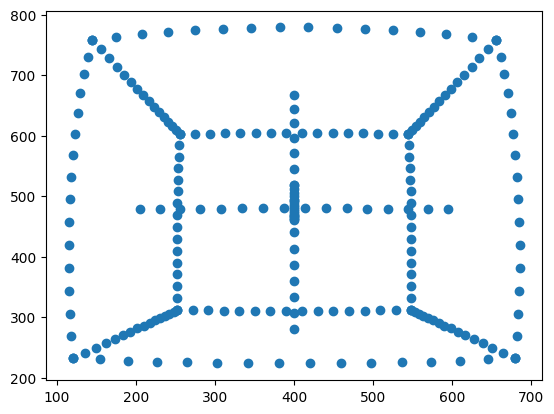

In [6]:
dist_coeffs = [-0.2]

Qp2 = projectPoints2(K, Rt, Q, dist_coeffs)
print(Qp2.shape)

plt.scatter(Qp2[0, :], Qp2[1, :])
plt.show()

**Where does the corner $\pmb{P}_1 = [-0.5, -0.5, -0.5]$ project to?** 

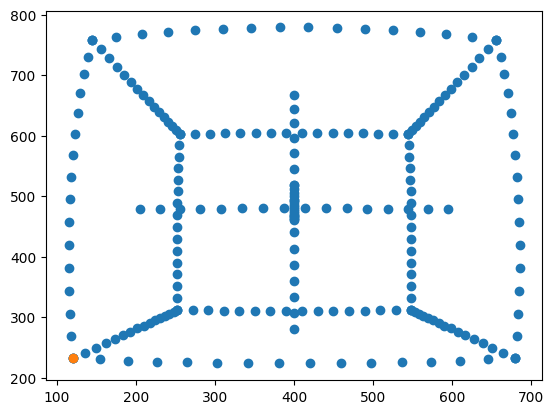

In [7]:
P1 = np.array([[-0.5, -0.5, -0.5]])
P1p2 = projectPoints2(K, Rt, P1.T, dist_coeffs)

plt.scatter(Qp2[0, :], Qp2[1, :])
plt.scatter(P1p2[0, :], P1p2[1, :])
plt.show()

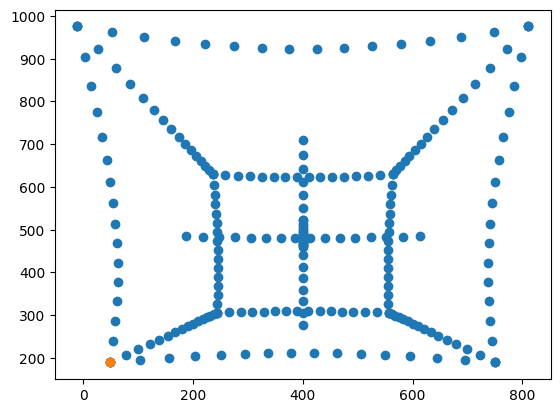

In [8]:
dist_coeffs2 = [0.5]
P1 = np.array([[-0.5, -0.5, -0.5]])
P1p3 = projectPoints2(K, Rt, P1.T, dist_coeffs2)
Qp3 = projectPoints2(K, Rt, Q, dist_coeffs2)

plt.scatter(Qp3[0, :], Qp3[1, :])
plt.scatter(P1p3[0, :], P1p3[1, :])
plt.show()

## Ex 2.3

### Response

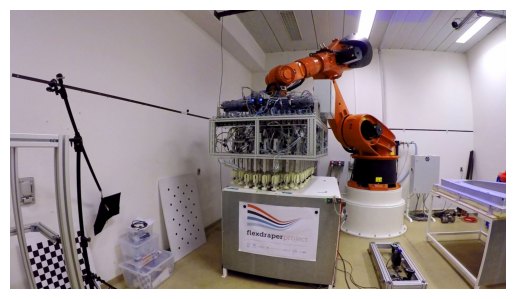

In [9]:
rgb_im = load_im("./ims/gopro_robot.jpg")
plt.imshow(rgb_im)
plt.axis("off")
plt.show()

**What is the camera matrix?**

In [10]:
def camera_matrix(f, deltax, deltay, alpha, beta):
    K =  np.array(
        [[f, beta*f, deltax],
        [0, alpha*f, deltay],
        [0, 0, 1]]
    )
    
    return K

In [11]:
f = 0.455732
alpha = 1
beta = 0
distort_coeffs3 = [-0.245031, 0.071524, -0.00994978]
deltax = rgb_im.shape[1]/2
deltay = rgb_im.shape[0]/2

print(f"deltax = {deltax}")
print(f"deltay = {deltay}")
print(f"focal length is: {f} times imagewidth {rgb_im.shape[1]}\n={round(f*rgb_im.shape[1],1)}")

focal_length = round(f*rgb_im.shape[1],1)

gopro_camMat = camera_matrix(focal_length, deltax, deltay, alpha, beta)
print("\nCamera Matrix:\n", gopro_camMat)



deltax = 960.0
deltay = 540.0
focal length is: 0.455732 times imagewidth 1920
=875.0

Camera Matrix:
 [[875.   0. 960.]
 [  0. 875. 540.]
 [  0.   0.   1.]]


## Ex 2.4
**Implement the function $\texttt{undistortImage}$**

### Response

In [12]:
def undistortImage(im, K, dist_coeffs):
    x, y = np.meshgrid(np.arange(im.shape[1]), np.arange(im.shape[0]))
    p = np.stack((x, y, np.ones(x.shape))).reshape(3, -1)
    
    #q = piInv(p)
    K_inv = np.linalg.inv(K)
    
    q_d = pi(K_inv @ p)
    
    r_squared = q_d[0,:]**2 + q_d[1,:]**2   
    
    delta_r = 0
    for i, coeff in enumerate(dist_coeffs):
        delta_r += coeff * r_squared**(i + 1)
    
    q_d *= (1 + delta_r)
    
    p_d = K @ piInv(q_d)
    
    print(q_d.shape)
    
    x_d = p_d[0].reshape(x.shape).astype(np.float32)
    y_d = p_d[1].reshape(y.shape).astype(np.float32)
    assert (p_d[2]==1).all(), 'You did a mistake somewhere'
    im_undistorted = cv2.remap(im, x_d, y_d, cv2.INTER_LINEAR)
    
    return im_undistorted
    

(2, 2073600)


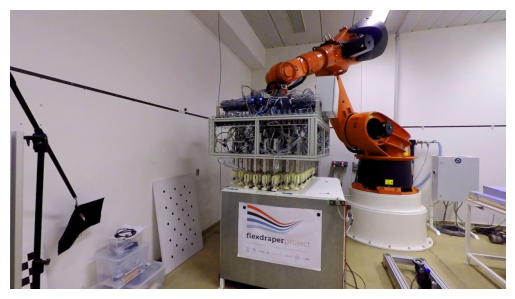

In [13]:
undistorted_im = undistortImage(rgb_im, gopro_camMat, distort_coeffs3)
plt.imshow(undistorted_im)
plt.axis("off")
plt.show()

## 2.5
There are points and we do a thing

### Response

In [14]:
# Anne's magic:
p2a = np.array([1, 1])
p2b = np.array([0, 3])
p2c = np.array([2, 3])
p2d = np.array([2, 4])

P2 = np.c_[p2a, p2b, p2c, p2d]
Q2 = piInv(P2)
print(f"Q2: \n{Q2}\n")

H = np.array(
    [[-2, 0, 1],
     [1, -2, 0],
     [0, 0, 3]]
    )

Q1 = H @ Q2

Q1 /= Q1[-1,:]

print(f"Q1: \n{Q1}")

Q2: 
[[1. 0. 2. 2.]
 [1. 3. 3. 4.]
 [1. 1. 1. 1.]]

Q1: 
[[-0.33333333  0.33333333 -1.         -1.        ]
 [-0.33333333 -2.         -1.33333333 -2.        ]
 [ 1.          1.          1.          1.        ]]


## Ex 2.6

Create the `hest` function.

In [15]:
def hest(q1, q2):
    """
        Takes two points in 2D and returns the estimated homography matrix.
    """
    
    if len(q1) != len(q2):
        raise ValueError("There must be an equal amount of points in the two sets!")
    
    Bi = []
    for i in range(q1.shape[1]):
        qi = q1[:,i]   # <-- getting the first column
        
        # Creating that weird qx matrix for the Kronecker product
        q1x = np.array(
            [[0,        -1, qi[1]],
             [1,        0, -qi[0]],
             [-qi[1], qi[0], 0]]
        )
        
        q2t_hom = q2[:, i].reshape(-1, 1) # <-- getting the first column and reshaping does for dim: (1, ) -> (1,1)
        Bi.append(np.kron(q2t_hom.T, q1x).reshape(3,9)) # <-- formula follows that of week 2, slide 56
       
    B = np.concatenate(Bi, axis=0)
    
    # Some TA prooved that it was unneseccary to find their dot product
    #BtB = B.T @ B
    V, Lambda, Vt = np.linalg.svd(B)
    Ht = Vt[-1, :]
    
    Ht = np.reshape(Ht, (3, 3))
    H = Ht.T
    
    return H
    
    

### Response 
Do the razzle-dazzle!

In [16]:
print(f"Q1: \n{Q1}\n\nQ2: \n{Q2}\n")
hest_answ = hest(Q1, Q2)
print(f"Answer from hest function: \n{hest_answ}\n")
print(f"Answer scaled: \n{hest_answ*(1/hest_answ[0][2])}\n")
print(f"True: \n{H}")

Q1: 
[[-0.33333333  0.33333333 -1.         -1.        ]
 [-0.33333333 -2.         -1.33333333 -2.        ]
 [ 1.          1.          1.          1.        ]]

Q2: 
[[1. 0. 2. 2.]
 [1. 3. 3. 4.]
 [1. 1. 1. 1.]]

Answer from hest function: 
[[ 4.58831468e-01  2.44596010e-16 -2.29415734e-01]
 [-2.29415734e-01  4.58831468e-01  1.44198889e-16]
 [ 1.55908272e-16 -8.28330460e-17 -6.88247202e-01]]

Answer scaled: 
[[-2.00000000e+00 -1.06616929e-15  1.00000000e+00]
 [ 1.00000000e+00 -2.00000000e+00 -6.28548385e-16]
 [-6.79588404e-16  3.61060877e-16  3.00000000e+00]]

True: 
[[-2  0  1]
 [ 1 -2  0]
 [ 0  0  3]]


## Ex 2.7

Create `normalize2d` the helper function.

### Response

In [17]:
def normalize2d(P : np.ndarray) -> np.ndarray:
    """
        Creates the T matrix from a given matrix!
    """
    mu_x = np.mean(P[0, :])
    mu_y = np.mean(P[1, :])
    sigma_x = np.std(P[0, :])
    sigma_y = np.std(P[1, :])
    
    T_inv = np.array(
        [[sigma_x, 0, mu_x],
         [0, sigma_y, mu_y],
         [0,       0,    1]]
    )
    
    T = np.linalg.inv(T_inv)
    
    return T

#### Testing the `normalize2d` function

In [18]:
print(f"Mean: \n{np.mean(Q2, axis=1)} \nand Standard deviation: \n{np.std(Q2, axis=1)}\nof Q2.")
T2 = normalize2d(Q2)
print(f"Mean: \n{np.mean(T2 @ Q2, axis=1)} \nand Standard deviation: \n{np.std(T2 @ Q2, axis=1)}\nof Q2 after normalization.")


Mean: 
[1.25 2.75 1.  ] 
and Standard deviation: 
[0.8291562  1.08972474 0.        ]
of Q2.
Mean: 
[-1.11022302e-16 -5.55111512e-17  1.00000000e+00] 
and Standard deviation: 
[1. 1. 0.]
of Q2 after normalization.


## Ex 2.8
Here we make an updated `hest`

### Response

In [19]:
def hest_v2(Q1 : np.ndarray, Q2 : np.ndarray, normalize=True) -> np.ndarray:
    """
        Takes two points in 2D and returns the estimated homography matrix.
    """
    
    if len(Q1) != len(Q2):
        raise ValueError("There must be an equal amount of points in the two sets!")
    
    if normalize:
        T1 = normalize2d(Q1)
        T2 = normalize2d(Q2)
        Q1 = T1 @ Q1
        Q2 = T2 @ Q2
        
    Bi = []
    for i in range(Q1.shape[1]):
        qi = Q1[:,i]   # <-- getting the first column
        
        # Creating that weird qx matrix for the Kronecker product
        q1x = np.array(
            [[0,        -1, qi[1]],
             [1,        0, -qi[0]],
             [-qi[1], qi[0], 0]]
        )
        
        q2t_hom = Q2[:, i].reshape(-1, 1) # <-- getting the first column and reshaping does for dim: (1, ) -> (1,1)
        Bi.append(np.kron(q2t_hom.T, q1x).reshape(3,9)) # <-- formula follows that of week 2, slide 56
       
    B = np.concatenate(Bi, axis=0)
    
    # Some TA prooved that it was unneseccary to find their dot product
    #BtB = B.T @ B
    V, Lambda, Vt = np.linalg.svd(B)
    Ht = Vt[-1, :]
    
    Ht = np.reshape(Ht, (3, 3))
    H = Ht.T
    
    if normalize:
        H = np.linalg.inv(T1) @ H @ T2
    
    return H
    
    

#### Testing the updated `hest` (`hest_v2`)

In [20]:
print(f"Q1: \n{Q1}\n\nQ2: \n{Q2}\n")
hest_answ2 = hest_v2(Q1, Q2)
print(f"Answer from hest function: \n{hest_answ2}\n")
print(f"Answer scaled: \n{hest_answ2*(1/hest_answ2[0][2])}\n")
print(f"True: \n{H}")

Q1: 
[[-0.33333333  0.33333333 -1.         -1.        ]
 [-0.33333333 -2.         -1.33333333 -2.        ]
 [ 1.          1.          1.          1.        ]]

Q2: 
[[1. 0. 2. 2.]
 [1. 3. 3. 4.]
 [1. 1. 1. 1.]]

Answer from hest function: 
[[-3.67070941e-01 -4.08935667e-17  1.83535471e-01]
 [ 1.83535471e-01 -3.67070941e-01 -1.11022302e-16]
 [ 0.00000000e+00  2.54702630e-17  5.50606412e-01]]

Answer scaled: 
[[-2.00000000e+00 -2.22810155e-16  1.00000000e+00]
 [ 1.00000000e+00 -2.00000000e+00 -6.04909242e-16]
 [ 0.00000000e+00  1.38775698e-16  3.00000000e+00]]

True: 
[[-2  0  1]
 [ 1 -2  0]
 [ 0  0  3]]


## Ex. 2.9
Random homography

In [21]:
np.random.seed(42)
Q2 = np.random.randn(2, 100)
Q2h = piInv(Q2)
H_true = np.random.randn(3, 3)
Q1h = H_true @ Q2h
Q1h /= Q1h[-1, :]

H_approx = hest_v2(Q1h, Q2h)
H_approx = H_approx*(H_true[0][2]/H_approx[0][2])

print(f"The True H: \n{H_true} \n\nThe estimated H: \n{H_approx} \n\nTheir difference: \n{H_true - H_approx}")


The True H: 
[[ 0.35778736  0.56078453  1.08305124]
 [ 1.05380205 -1.37766937 -0.93782504]
 [ 0.51503527  0.51378595  0.51504769]] 

The estimated H: 
[[ 0.35778736  0.56078453  1.08305124]
 [ 1.05380205 -1.37766937 -0.93782504]
 [ 0.51503527  0.51378595  0.51504769]] 

Their difference: 
[[-6.66133815e-16  1.22124533e-15  0.00000000e+00]
 [ 3.44169138e-14  2.50910404e-14  1.27675648e-14]
 [-2.44249065e-15 -2.44249065e-15 -2.33146835e-15]]


## Ex. 2.10
We have to some *funky* shizzle with the points on a paper

### Response
First I show the images

C:\Users\daflo\AppData\Local\Temp\ipykernel_9304\1649568230.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


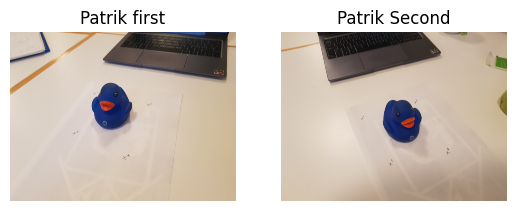

In [22]:
patrick_1 = load_im(path="./ims/patrick_01.jpg")
patrick_2 = load_im(path="./ims/patrick_02.jpg")

fig, ax = plt.subplots(1,2)

ax[0].imshow(patrick_1)
ax[0].set_axis_off()
ax[0].set_title("Patrik first")

ax[1].imshow(patrick_2)
ax[1].set_axis_off()
ax[1].set_title("Patrik Second")

fig.show()



Secondly I get the mapped points

In [23]:
POINTS_PATH_1 = "./data/patrick_1_pnts.npy"
POINTS_PATH_2 = "./data/patrick_2_pnts.npy"

if not os.path.exists(POINTS_PATH_1) or not os.path.exists(POINTS_PATH_2):
    raise Exception("Some of the points haven't been saved yet. Go run 'ex_2_10.py' as I can't get it to work in a Jupyter notebook...")

patrick_1_pnts = np.load(POINTS_PATH_1)
patrick_2_pnts = np.load(POINTS_PATH_2)

print(patrick_1_pnts)
print(patrick_2_pnts)
    


[[1506.97272727 1112.22727273]
 [2466.97272727 1312.95454545]
 [1149.15454545 1810.40909091]
 [2039.33636364 2255.5       ]]
[[1445.88181818 1557.31818182]
 [2401.51818182 1269.31818182]
 [1952.06363636 2360.22727273]
 [2973.15454545 2155.13636364]]


#### Trying to create the homography

In [24]:
pat_1_hom = piInv(patrick_1_pnts.T)
pat_2_hom = piInv(patrick_2_pnts.T)
print(f"pat_1_hom: \n{pat_1_hom}\n")
print(f"pat_2_hom: \n{pat_2_hom}\n")

H_approx2 = hest_v2(Q1h, Q2h)

print(H_approx2)


pat_1_hom: 
[[1.50697273e+03 2.46697273e+03 1.14915455e+03 2.03933636e+03]
 [1.11222727e+03 1.31295455e+03 1.81040909e+03 2.25550000e+03]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00]]

pat_2_hom: 
[[1.44588182e+03 2.40151818e+03 1.95206364e+03 2.97315455e+03]
 [1.55731818e+03 1.26931818e+03 2.36022727e+03 2.15513636e+03]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00]]

[[-0.43056684 -0.67485677 -1.30336061]
 [-1.26816168  1.65790861  1.12859315]
 [-0.6198014  -0.61829795 -0.61981635]]


Trying to get `H_approx2` to work by using the points!

In [25]:
pat_2_approx = H_approx2 @ pat_1_hom
print(f"Pat 2 true: \n{pat_2_hom}\n")
print(f"Pat 1 with the homography: \n{pat_2_approx}\n")


Pat 2 true: 
[[1.44588182e+03 2.40151818e+03 1.95206364e+03 2.97315455e+03]
 [1.55731818e+03 1.26931818e+03 2.36022727e+03 2.15513636e+03]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00]]

Pat 1 with the homography: 
[[-1400.74994661 -1949.55627099 -1717.85802743 -2401.51341151]
 [  -65.98529542  -950.63303201  1545.30765924  1154.33324234]
 [-1622.33147244 -2341.4500799  -1832.23965217 -2659.17438929]]



#### Testing the homography
*shizzle don't work, fam*


Test point: 
[[1882.24545455 1138.40909091]]

Test point homographied (before transform): 
[[-1579.99891597]
 [ -498.48472502]
 [-1871.11419931]]

Test point homographied (after transform): 
[[1579.99891597]
 [ 498.48472502]
 [1871.11419931]]



C:\Users\daflo\AppData\Local\Temp\ipykernel_9304\2878664647.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


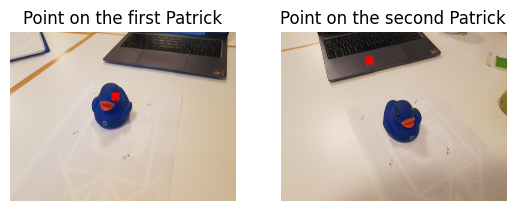

In [26]:
TEST_POINT_PATH = "./data/test_point.npy"

if not os.path.exists(TEST_POINT_PATH):
    raise Exception("Please go and run 'ex_2_10.py' to create a test point. Don't know how to do it in a Jupyter Notebook")

test_point = np.load(TEST_POINT_PATH)

test_point_hom = piInv(test_point.T)
print(f"Test point: \n{test_point}\n")
test_point_on_pat2 = H_approx2 @ test_point_hom

print(f"Test point homographied (before transform): \n{test_point_on_pat2}\n")
test_point_on_pat2 *= (-1)

print(f"Test point homographied (after transform): \n{test_point_on_pat2}\n")

fig, ax = plt.subplots(1,2)

ax[0].imshow(patrick_1)
ax[0].plot(test_point_hom[0], test_point_hom[1], marker="X", color="red")
ax[0].set_axis_off()
ax[0].set_title("Point on the first Patrick")

ax[1].imshow(patrick_2)
ax[1].plot(test_point_on_pat2[0], test_point_on_pat2[1], marker="X", color="red")
ax[1].set_axis_off()
ax[1].set_title("Point on the second Patrick")

fig.show()

## Ex 2.11
Trying to create the second image from the first by using cv2s warpPerspective.

### Response
*This is hella wack*

C:\Users\daflo\AppData\Local\Temp\ipykernel_9304\1648694691.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


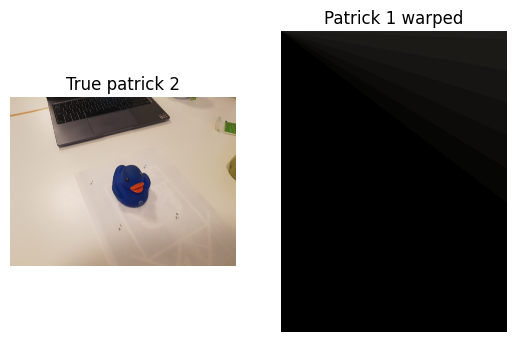

In [27]:
imWarp = cv2.warpPerspective(patrick_1, H_approx2, (patrick_1.shape[0], patrick_1.shape[1]))

fig, ax = plt.subplots(1,2)

ax[0].imshow(patrick_2)
ax[0].set_axis_off()
ax[0].set_title("True patrick 2")

ax[1].imshow(imWarp)
ax[1].set_axis_off()
ax[1].set_title("Patrick 1 warped")

fig.show()

